In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import json
import pandas as pd
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

Functions declaration

In [6]:
## -- FUNCTIONS DEFINITION

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new 

In [7]:
# -- Path for netcdf files
# out_path = "C:/Users/mastr/Documents/Amazon/RESULTS/validation/"
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS'


## Open FLUXCOM data
Carbon and Energy Fluxes (RS_METEO) based on WFDEI climatological forcing dataset (https://rda.ucar.edu/datasets/ds314.2/), covering the period 197901 - 201312

GPP is DOWNWARD flux of Carbon (out of atmosphere) \
TER is UPWARD flux of Carbon (into the atmosphere) \
NEP in FLUXCOM represents UPWARD flux of Carbon (into atmosphere) whereas in ESM represents DOWNWARD flux of carbon (out of atmosphere)

In [8]:
data_path = 'D:/Data/Reanalysis/'               

# Carbon Fluxes
file = "nee_wfdei_197901-201312.nc" 
ds_nep_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_nep_flux = ds_nep_flux.isel(lat=slice(None, None, -1))

file = "ter_wfdei_197901-201312.nc" 
ds_ter_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_ter_flux = ds_ter_flux.isel(lat=slice(None, None, -1))

file = "gpp_wfdei_197901-201312.nc" 
ds_gpp_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/CarbonFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_gpp_flux = ds_gpp_flux.isel(lat=slice(None, None, -1))
#ds_pr = ds_pr.assign_coords(lat=(ds_pr.lat + 0.5)); 

# Energy Fluxes
file = "h_wfdei_197901-201312.nc" 
ds_h_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_h_flux = ds_h_flux.isel(lat=slice(None, None, -1))

file = "le_wfdei_197901-201312.nc" 
ds_le_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_le_flux = ds_le_flux.isel(lat=slice(None, None, -1))

file = "rn_wfdei_197901-201312.nc" 
ds_rn_flux = xr.open_dataset(os.path.join(data_path+'fluxcom/EnergyFluxes/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #ds_pr = ds_pr.mean(axis=0)
ds_rn_flux = ds_rn_flux.isel(lat=slice(None, None, -1))


In [9]:
# Convert dataset to dataarray

ds_nep_flux = ds_nep_flux.NEE; ds_ter_flux = ds_ter_flux.TER; ds_gpp_flux = ds_gpp_flux.GPP
ds_h_flux = ds_h_flux.H; ds_le_flux = ds_le_flux.LE; ds_rn_flux = ds_rn_flux.Rn

## Open ERA5 data

Precipitation and Temperature donwloaded from ERA5 reanalyses (0.5x0.5), whereas Soil Moisture and LAI from ERA5-Land reanalyses (0.25x0.25)

In [10]:
data_path = 'D:/Data/Reanalysis/'   

file = "era5_tp_195001-201612_raw_f32.nc" 
ds_pr_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"]) #ds_pr = ds_pr.mean(axis=0)
ds_pr_era5 = ds_pr_era5.rename(latitude = "lat", longitude = "lon")
ds_pr_era5 = ds_pr_era5.isel(lat=slice(None, None, -1))

file = "era5_mrso_195001-201812.nc"
ds_mrso_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"])
ds_mrso_era5 = ds_mrso_era5.rename(latitude = "lat", longitude = "lon")
ds_mrso_era5 = ds_mrso_era5.isel(lat=slice(None, None, -1))

file = "era5_tas_195001-201612_raw_f32.nc"
ds_tas_era5 = xr.open_dataset(os.path.join(data_path+'era5/'+file), drop_variables=["time_bnds","lon_bnds","lat_bnds"])
ds_tas_era5 = ds_tas_era5.rename(latitude = "lat", longitude = "lon")
ds_tas_era5 = ds_tas_era5.isel(lat=slice(None, None, -1))


In [11]:
# Convert dataset to dataarray
ds_pr_era5 = ds_pr_era5.tp; ds_mrso_era5 = ds_mrso_era5.mrso; ds_tas_era5 = ds_tas_era5.t2m

## Open ESM data

In [12]:
data_path = 'D:/Data/analysis/'              
scenario = 'historical'

# Carbon Fluxes
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):               # List of files sorted by name
        content = nc.Dataset(filepath).parent_source_id
        files_list.append(content)

ds_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_nep.append(content)

## -- Correct E3SM dataarray by masking values of 1e+20 over ocean
for i, item in enumerate(files_list):
    if files_list[i] == 'E3SM-1-1-ECA' and var_name == "nep":
        ds_nep[i] = ds_nep[i].where((ds_nep[i]< 5000)&(ds_nep[i]> -5000))   
    elif files_list[i] == 'E3SM-1-1-ECA' and (var_name == "ter" or var_name =="gpp"):
        ds_nep[i] = ds_nep[i].where((ds_nep[i]< 10000))   

esm = []
for filepath in sorted(glob.glob(os.path.join('D:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_nep[i] = ds_nep[i]*-1
        else:
                None

var_name = 'gpp'
ds_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_gpp.append(content)

var_name = 'ter'
ds_ter = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_ter.append(content)

# Energy Fluxes
var_name = 'hfls'
ds_le = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_le.append(content)

var_name = 'rsds'
ds_rn = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_rn.append(content)

# Climatological
var_name = 'pr'
ds_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_pr.append(content)

var_name = 'mrso'
ds_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_mrso.append(content)

var_name = 'tas'
ds_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+var_name + '_*_' + scenario + '_*'))):                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])[var_name]; #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_tas.append(content)

# Correct values of E3SM
for i,item in enumerate(ds_tas[6]):
    if item.mean(...) < 0:
        print(i)
        ds_tas[6][i] = ds_tas[6][:250].groupby('time.month').mean(dim = "time")[0].values
    else:
       None

## Preprocessing 

### Convert units

In [13]:
# Carbon fluxes convertion
ds_nep_flux = ds_nep_flux * 365 * -1
ds_nep_flux.attrs['units'] = 'gC m-2 y-1'

ds_gpp_flux = ds_gpp_flux * 365
ds_gpp_flux.attrs['units'] = 'gC m-2 y-1'

ds_ter_flux = ds_ter_flux * 365
ds_ter_flux.attrs['units'] = 'gC m-2 y-1' 

# Energy fluxes convertion
ds_h_flux = ds_h_flux * 1/0.0864        # 1J = 1W*s
ds_h_flux.attrs['units'] = 'W m-2'

ds_le_flux = ds_le_flux * 1/0.0864      # 1J = 1W*s
ds_le_flux.attrs['units'] = 'W m-2'

ds_rn_flux = ds_rn_flux * 1/0.0864      # 1J = 1W*s
ds_rn_flux.attrs['units'] = 'W m-2' 

ds_et_flux = ds_le_flux * (1/30) * (1/2.453)
ds_et_flux.attrs['units'] = 'mm month-1'

# Precipitation  & Soil Moisture conversion
ds_pr_era5 = ds_pr_era5 * 1000  # convert meter to mm/day by multiplying with 1000*24/step (step is 24 hrs in this case)
ds_pr_era5 = ds_pr_era5 * ds_pr_era5.time.dt.days_in_month
ds_pr_era5.attrs['units'] = 'mm month-1'

ds_mrso_era5 = ds_mrso_era5 
ds_mrso_era5.attrs['units'] = 'kg m-2'

ds_tas_era5 = ds_tas_era5 - 273.15
ds_tas_era5.attrs['units'] = '°C'

### Regridding to common 1 x 1 grid and select common time period 197901 - 201312

In [14]:
import xesmf as xe

def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

# Define Longitude from -180 to 180
ds_nep_flux = lon180(ds_nep_flux); ds_gpp_flux = lon180(ds_gpp_flux); ds_ter_flux = lon180(ds_ter_flux)
ds_le_flux = lon180(ds_le_flux); ds_rn_flux = lon180(ds_rn_flux)
ds_pr_era5 = lon180(ds_pr_era5); ds_tas_era5 = lon180(ds_tas_era5); ds_mrso_era5 = lon180(ds_mrso_era5)

# Select period from 197901 to 201312
ds_nep_flux = ds_nep_flux.sel(time = slice("1979-01", "2013-12")); ds_gpp_flux = ds_gpp_flux.sel(time = slice("1979-01", "2013-12")); ds_ter_flux = ds_ter_flux.sel(time = slice("1979-01", "2013-12"))
ds_le_flux = ds_le_flux.sel(time = slice("1979-01", "2013-12")); ds_rn_flux = ds_rn_flux.sel(time = slice("1979-01", "2013-12"))
ds_pr_era5 = ds_pr_era5.sel(time = slice("1979-01", "2013-12")); ds_tas_era5 = ds_tas_era5.sel(time = slice("1979-01", "2013-12")); ds_mrso_era5 = ds_mrso_era5.sel(time = slice("1979-01", "2013-12"))

# Select lon lat of Amazon basin
ds_nep_flux = ds_nep_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_gpp_flux = ds_gpp_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_ter_flux = ds_ter_flux.sel(lon = slice(-85, -30), lat = slice(-30,15))
ds_le_flux = ds_le_flux.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_rn_flux = ds_rn_flux.sel(lon = slice(-85, -30), lat = slice(-30,15))
ds_pr_era5 = ds_pr_era5.sel(lon = slice(-85, -30), lat = slice(-30,15)); ds_tas_era5 = ds_tas_era5.sel(lon = slice(-85, -30), lat = slice(-30,15))

# Regrid ERA5 data to FLUXCOM resolution
ds_out = xe.util.cf_grid_2d(-85, -30, 1, -30, 15, 1)

regrid_nep_flux = xe.Regridder(ds_nep_flux, ds_out, "bilinear")
regrid_pr_era5 = xe.Regridder(ds_pr_era5, ds_out, "bilinear")
regrid_tas_era5 = xe.Regridder(ds_tas_era5, ds_out, "bilinear")
regrid_mrso_era5 = xe.Regridder(ds_mrso_era5, ds_out, "bilinear")

ds_nep_flux = regrid_nep_flux(ds_nep_flux, keep_attrs=True); ds_gpp_flux = regrid_nep_flux(ds_gpp_flux, keep_attrs=True); ds_ter_flux = regrid_nep_flux(ds_ter_flux, keep_attrs=True)
ds_le_flux = regrid_nep_flux(ds_le_flux, keep_attrs=True); ds_rn_flux = regrid_nep_flux(ds_rn_flux, keep_attrs=True)
ds_pr_era5 = regrid_pr_era5(ds_pr_era5, keep_attrs=True); ds_tas_era5 = regrid_tas_era5(ds_tas_era5, keep_attrs=True); ds_mrso_era5 = regrid_mrso_era5(ds_mrso_era5, keep_attrs=True)


In [15]:
# Define Longitude from -180 to 180
ds_nep = [lon180(a) for a in ds_nep]; ds_gpp = [lon180(a) for a in ds_gpp]; ds_ter = [lon180(a) for a in ds_ter]
ds_le = [lon180(a) for a in ds_le]; ds_rn = [lon180(a) for a in ds_rn]
ds_pr = [lon180(a) for a in ds_pr]; ds_tas = [lon180(a) for a in ds_tas]; ds_mrso = [lon180(a) for a in ds_mrso]

# Select period from 197901 to 201312
ds_nep = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_nep]; ds_gpp = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_gpp]; ds_ter = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_ter]; 
ds_le = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_le]; ds_rn = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_rn]
ds_pr = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_pr]; ds_mrso = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_mrso]; ds_tas = [a.sel(time = slice("1979-01", "2013-12")) for a in ds_tas]

# Select lon lat of Amazon basin
ds_nep = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_nep]; ds_gpp = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_gpp]; ds_ter = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_ter]; 
ds_le = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_le]; ds_rn = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_rn]
ds_pr = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_pr]; ds_mrso = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_mrso]; ds_tas = [a.sel(lon = slice(-85, -30), lat = slice(-30,15)) for a in ds_tas]

# Regrid to 1 x 1 
ds_out = xe.util.cf_grid_2d(-85, -30, 1, -30, 15, 1)

regrid = [xe.Regridder(a, ds_out, "bilinear") for a in ds_nep]

ds_nep = [regr(a, keep_attrs=True) for a,regr in zip(ds_nep,regrid)]; ds_gpp = [regr(a, keep_attrs=True) for a,regr in zip(ds_gpp,regrid)]; ds_ter = [regr(a, keep_attrs=True) for a,regr in zip(ds_ter,regrid)]
ds_le = [regr(a, keep_attrs=True) for a,regr in zip(ds_le,regrid)]; ds_rn = [regr(a, keep_attrs=True) for a,regr in zip(ds_rn,regrid)]
ds_pr = [regr(a, keep_attrs=True) for a,regr in zip(ds_pr,regrid)]; ds_mrso = [regr(a, keep_attrs=True) for a,regr in zip(ds_mrso,regrid)]; ds_tas = [regr(a, keep_attrs=True) for a,regr in zip(ds_tas,regrid)]

## Bias Scatterplot

In [16]:
# Assign common time coordinate
for i,item in enumerate(ds_gpp):
    ds_gpp[i]["time"] = ds_nep_flux.time.values
    ds_nep[i]["time"] = ds_nep_flux.time.values
    ds_ter[i]["time"] = ds_nep_flux.time.values
    ds_pr[i]["time"] = ds_nep_flux.time.values
    ds_tas[i]["time"] = ds_nep_flux.time.values
    ds_mrso[i]["time"] = ds_nep_flux.time.values
    ds_le[i]["time"] = ds_nep_flux.time.values
    ds_rn[i]["time"] = ds_nep_flux.time.values

ds_pr_era5["time"] = ds_nep_flux.time.values; ds_tas_era5["time"] = ds_nep_flux.time.values; ds_mrso_era5["time"] = ds_nep_flux.time.values; 


In [17]:
# Zonal mean of renalysis and ESM
def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_m.groupby("region").mean(...)
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

ds_nep_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_nep]; ds_gpp_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_gpp]; ds_ter_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_ter]
ds_le_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_le]; ds_rn_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_rn]
ds_pr_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_pr]; ds_tas_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_tas]; ds_mrso_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_mrso]

ds_nep_flux_amz = zonal_stat(ds_nep_flux, geodf).sel(region = 1); ds_gpp_flux_amz = zonal_stat(ds_gpp_flux, geodf).sel(region = 1); ds_ter_flux_amz = zonal_stat(ds_ter_flux, geodf).sel(region = 1)
ds_pr_era5_amz = zonal_stat(ds_pr_era5, geodf).sel(region = 1); ds_tas_era5_amz = zonal_stat(ds_tas_era5, geodf).sel(region = 1); ds_mrso_era5_amz = zonal_stat(ds_mrso_era5, geodf).sel(region = 1)
ds_le_flux_amz = zonal_stat(ds_le_flux, geodf).sel(region = 1); ds_rn_flux_amz = zonal_stat(ds_rn_flux, geodf).sel(region = 1)

Biases

In [18]:
# Compute bias for the Amazon basin
bias_nep_amz = [(a - ds_nep_flux_amz).mean(dim = "time") for a in ds_nep_amz]
bias_gpp_amz = [(a - ds_gpp_flux_amz).mean(dim = "time") for a in ds_gpp_amz]
bias_ter_amz = [(a - ds_ter_flux_amz).mean(dim = "time") for a in ds_ter_amz]
bias_le_amz = [(a - ds_le_flux_amz).mean(dim = "time") for a in ds_le_amz]
bias_rn_amz = [(a - ds_rn_flux_amz).mean(dim = "time") for a in ds_rn_amz]
bias_pr_amz = [(zonal_stat(a, geodf).sel(region = 1).groupby('time.year').sum(dim = 'time').mean(dim = 'year') - ds_pr_era5_amz.groupby('time.year').sum(dim = 'time').mean(dim = 'year')) for a in ds_pr]
bias_tas_amz = [(a - ds_tas_era5_amz).mean(dim = "time") for a in ds_tas_amz]
bias_mrso_amz = [(a - ds_mrso_era5_amz).mean(dim = "time") for a in ds_mrso_amz]

# Concatenate over "esm" dimension in a xarray
# Convert to pandas dataframe
bias_pr_amz = xr.concat(bias_pr_amz, dim = "esm")
bias_nep_amz = xr.concat(bias_nep_amz, dim = "esm"); bias_nep_amz = bias_nep_amz.rename("nep")
bias_gpp_amz = xr.concat(bias_gpp_amz, dim = "esm"); bias_gpp_amz = bias_gpp_amz.rename("gpp")
bias_ter_amz = xr.concat(bias_ter_amz, dim = "esm"); bias_ter_amz = bias_ter_amz.rename("ter")
bias_le_amz = xr.concat(bias_le_amz, dim = "esm"); bias_le_amz = bias_le_amz.rename("le")
bias_rn_amz = xr.concat(bias_rn_amz, dim = "esm"); bias_rn_amz = bias_rn_amz.rename("rn")
bias_mrso_amz = xr.concat(bias_mrso_amz, dim = "esm")
bias_tas_amz = xr.concat(bias_tas_amz, dim = "esm", coords='minimal', compat='override'); bias_tas_amz = bias_tas_amz.rename("tas")

# Convert to pandas dataframe
df_bias_nep_amz = bias_nep_amz.to_dataframe(); df_bias_nep_amz = df_bias_nep_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_bias_nep_amz.index, files_list)))
df_bias_pr_amz = bias_pr_amz.to_dataframe(name = "pr"); df_bias_pr_amz = df_bias_pr_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_bias_pr_amz.index, files_list)))
df_bias_tas_amz = bias_tas_amz.to_dataframe(); df_bias_tas_amz = df_bias_tas_amz.drop(columns = ["latitude_longitude","region", "height"]).rename(index=dict(zip(df_bias_tas_amz.index, files_list)))
df_bias_gpp_amz = bias_gpp_amz.to_dataframe(); df_bias_gpp_amz = df_bias_gpp_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_bias_gpp_amz.index, files_list)))
df_bias_ter_amz = bias_ter_amz.to_dataframe(); df_bias_ter_amz = df_bias_ter_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_bias_ter_amz.index, files_list)))
df_bias_mrso_amz = bias_mrso_amz.to_dataframe(); df_bias_mrso_amz = df_bias_mrso_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_bias_mrso_amz.index, files_list)))
df_bias_le_amz = bias_le_amz.to_dataframe(); df_bias_le_amz = df_bias_le_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_bias_le_amz.index, files_list)))
df_bias_rn_amz = bias_rn_amz.to_dataframe(); df_bias_rn_amz = df_bias_rn_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_bias_rn_amz.index, files_list)))

df_bias = pd.concat([df_bias_nep_amz, df_bias_pr_amz, df_bias_tas_amz, df_bias_gpp_amz, df_bias_ter_amz, df_bias_mrso_amz, df_bias_le_amz, df_bias_rn_amz], axis = 1)
df_bias.set_axis(["bias_nep","bias_pr","bias_tas","bias_gpp","bias_ter","bias_mrso","bias_le","bias_rn"], axis=1, inplace=True)



ESM zonal values

In [19]:
# Convert to pandas dataframe
df_nep_amz =  xr.concat(ds_nep_amz, dim = "esm").to_dataframe(); df_nep_amz = df_nep_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_nep_amz.index, files_list)))
df_pr_amz = xr.concat(ds_pr_amz, dim = "esm").to_dataframe(); df_pr_amz = df_pr_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_pr_amz.index, files_list)))
df_tas_amz =  xr.concat(ds_tas_amz, dim = "esm", coords='minimal', compat='override').to_dataframe(); df_tas_amz = df_tas_amz.drop(columns = ["latitude_longitude","region", "height"]).rename(index=dict(zip(df_tas_amz.index, files_list)))
df_gpp_amz =  xr.concat(ds_gpp_amz, dim = "esm").to_dataframe(); df_gpp_amz = df_gpp_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_gpp_amz.index, files_list)))
df_ter_amz =  xr.concat(ds_ter_amz, dim = "esm").to_dataframe(); df_ter_amz = df_ter_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_ter_amz.index, files_list)))
df_mrso_amz = xr.concat(ds_mrso_amz, dim = "esm").to_dataframe(); df_mrso_amz = df_mrso_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_mrso_amz.index, files_list)))
df_le_amz = xr.concat(ds_le_amz, dim = "esm").to_dataframe(); df_le_amz = df_le_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_le_amz.index, files_list)))
df_rn_amz = xr.concat(ds_rn_amz, dim = "esm").to_dataframe(); df_rn_amz = df_rn_amz.drop(columns = ["latitude_longitude","region"]).rename(index=dict(zip(df_rn_amz.index, files_list)))

df_amz = pd.concat([df_nep_amz, df_pr_amz, df_tas_amz, df_gpp_amz, df_ter_amz, df_mrso_amz, df_le_amz, df_rn_amz], axis = 1)
df_amz.set_axis(["nep","pr","tas","gpp","ter","mrso","le","rn"], axis=1, inplace=True)


In [20]:
df_amz_bias = pd.concat([df_amz,df_bias], axis=1)

In [21]:
df_amz_bias

,nep,pr,tas,gpp,ter,mrso,le,rn,bias_nep,bias_pr,bias_tas,bias_gpp,bias_ter,bias_mrso,bias_le,bias_rn
esm,,,,,,,,,,,,,,,,
ACCESS-ESM1-5,8.229717,211.140235,26.757964,1827.084799,1818.855083,1527.702309,111.492051,237.842452,-468.442634,248.330527,2.344671,-723.784467,-180.510534,384.322186,18.185662,114.784939
ACCESS-ESM1-5,16.039115,211.404872,26.780000,1829.538402,1813.499286,1526.947084,111.243492,238.069263,-460.633235,251.506174,2.366707,-721.330865,-185.866330,383.566962,17.937102,115.011750
ACCESS-ESM1-5,10.027571,210.326311,26.705621,1828.543121,1818.515549,1526.390021,111.102762,237.808424,-466.644779,238.563447,2.292328,-722.326146,-180.850067,383.009899,17.796373,114.750912
ACCESS-ESM1-5,1.849029,208.383183,26.795899,1806.362668,1804.513638,1522.067228,110.663616,238.361893,-474.823321,215.245910,2.382606,-744.506599,-194.851978,378.687105,17.357226,115.304380
ACCESS-ESM1-5,17.176098,215.274607,26.632514,1841.312892,1824.136794,1534.181072,112.286224,236.651182,-459.496253,297.942995,2.219221,-709.556374,-175.228823,390.800949,18.979835,113.593669
BCC-CSM2-MR,101.487325,161.774498,25.844932,2145.487771,2044.000446,451.318457,100.348693,242.670271,-375.185026,-344.058312,1.431639,-405.381496,44.634830,-692.061665,7.042304,119.612758
CESM2-WACCM,47.301594,162.354693,25.272690,2020.692485,2067.994079,2271.598759,90.644581,210.833726,-429.370757,-337.095976,0.859397,-530.176781,68.628462,1128.218637,-2.661808,87.776213
CESM2-WACCM,44.211500,161.452750,25.354294,2035.731115,2079.942616,2274.082093,90.909987,210.663573,-432.460850,-347.919289,0.941001,-515.138151,80.576999,1130.701970,-2.396402,87.606060
CESM2-WACCM,44.489316,162.600085,25.443810,2027.793850,2072.283167,2272.451198,91.160806,210.409756,-432.183034,-334.151275,1.030517,-523.075417,72.917550,1129.071076,-2.145584,87.352243


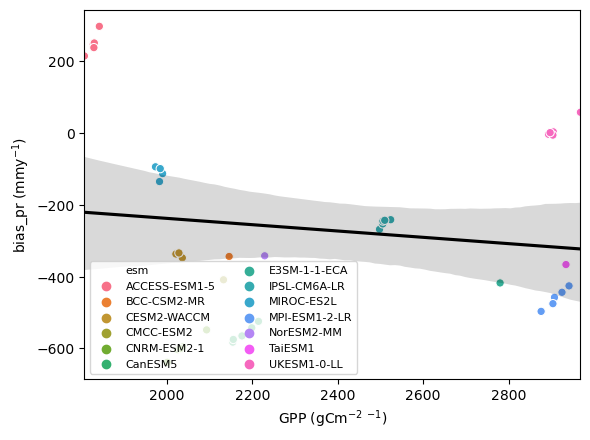

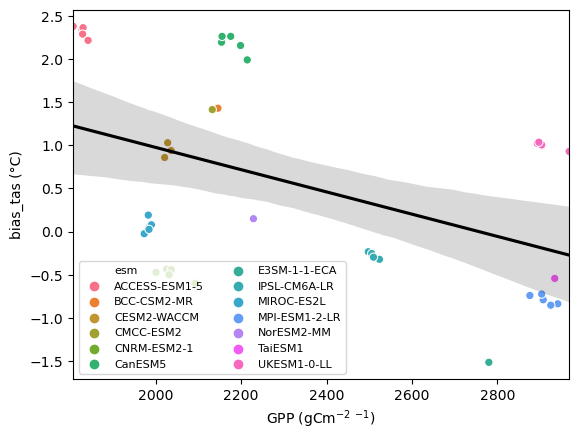

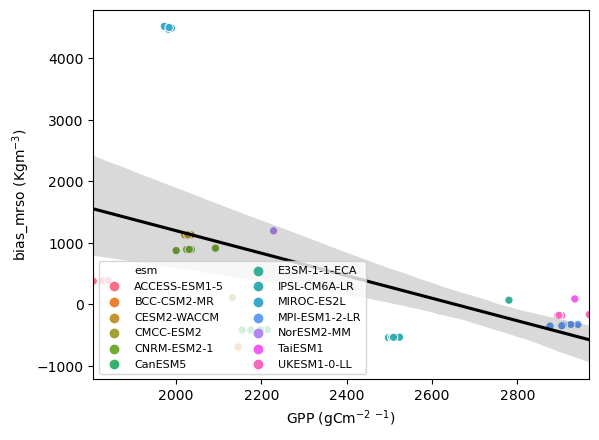

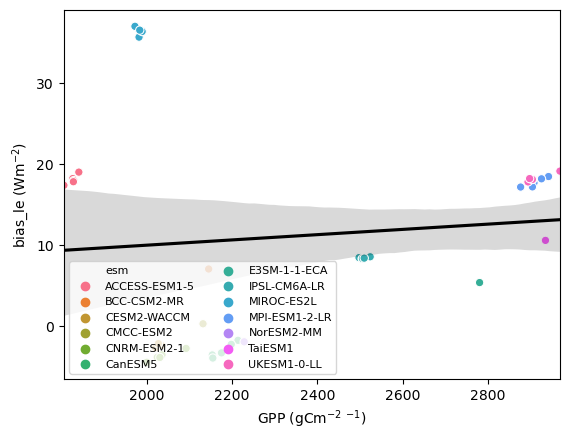

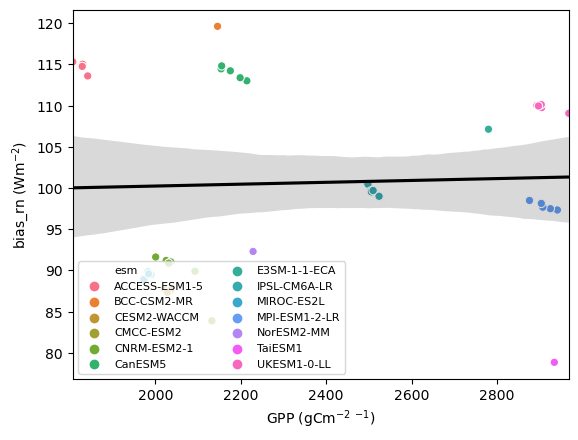

In [26]:
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/'

from scipy import stats
import seaborn as sns
i = 0
units = ["mmy$^{-1}$", "°C", "Kgm$^{-3}$", "Wm$^{-2}$", "Wm$^{-2}$"]
for predictor in ["bias_pr", "bias_tas", "bias_mrso", "bias_le", "bias_rn"]:
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax = sns.scatterplot(x = "gpp", y = predictor, data=df_amz_bias, hue=df_amz_bias.index)
    ax = sns.regplot(x="gpp", y=predictor, data=df_amz_bias, scatter=False, line_kws={"color": "black"})
    ax.set(xlabel='GPP (gCm$^{-2}$ $^{-1}$)', ylabel = predictor + " (" + units[i] +")" )#, ylabel=' Bias precipitation (mm)')
    # ax.text(.05, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_amz_bias['nep'],df_amz_bias[predictor]).rvalue),
            # transform=ax.transAxes, fontsize = 10)
    # title= "MSC model diversity - " + predictor
    # ax.set_title("b) Zonal mean-state changes model diversity")
    ax.legend(loc='lower left', ncol=2, fontsize = 8)
    # output_file = os.path.join(out_path, title) + ".png"
#     plt.savefig(output_file, bbox_inches='tight')
    i = i+1

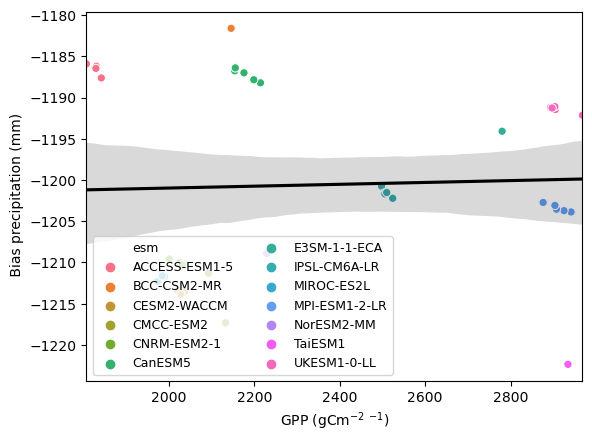

In [20]:
import seaborn as sns

# GPP vs pr
fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot(x='gpp', y='bias_rn', data=df_amz_bias, hue=df_amz_bias.index)
ax = sns.regplot(x='gpp', y='bias_rn', data=df_amz_bias, scatter=False, line_kws={"color": "black"})
ax.set(xlabel='GPP (gCm$^{-2}$ $^{-1}$)', ylabel=' Bias precipitation (mm)')
plt.legend(loc='lower left', ncol = 2, fontsize = 9)
plt.show()
title = "scatter gpp - bias_pr"
output_file = os.path.join(out_path,"validation_" + title.replace('/','_')) + ".png"
# fig.savefig(output_file, bbox_inches='tight')


## Unite ESM and ERA5 

In [ ]:
# Append fluxcom data to ESM

DS_data = []
for i, item in enumerate(DS_models):
    content = xr.DataArray.copy(DS_models[i])
    DS_data.append(content)
DS_data.insert(0,DS_obs)
data_list = list(np.unique(files_list)); data_list.insert(0,"FLUXCOM")

# DS_Data statistics

DS_data_ymean = [(a.mean(dim = 'time')) for a in DS_data]
DS_data_seasmean = [(a.sel(time = a.time.dt.season == seas).mean(dim = "time")) for a in DS_data]
DS_data_monmean = [(a.groupby('time.month').mean(dim = 'time')) for a in DS_data]


### Plot BIAS

In [ ]:
#### ------- MULTIMODEL PLOT -------- ####
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

data_plot = bias_seasmean

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30 
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                     #automatic colorbar limits
cbar_position = "top"
                                                     
# --- Title & Axes labels
if var_name == 'pr':
    title = 'Bias precipitation' + " - " +"1980/2010 DJF Mean"
    cbar_label = "mmy$^{-1}$"
    cmap = "RdBu"
elif var_name == 'mrso':
    title = 'Bias soil moisture' + " - " +"1980/2010 DJF Mean"
    cbar_label = "Kgm$^{-2}$"
    cmap = "BrBG"  
elif var_name == 'tas':
    title = 'Bias temperature' + " - " +"1980/2010 DJF Mean"
    cbar_label = "degC"
    cmap = "RdYlBu_r"

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    lons = data_plot[i].lon
    lats = data_plot[i].lat

    if var_name == "pr":
        min_value, max_value, bins_value = -800, 800, 20              # Precipitation
        v = np.linspace(min_value, max_value, bins_value, endpoint=True)

    if var_name == "tas":
        min_value, max_value, bins_value = -6, +6, 20              # Temperature
        v = np.linspace(min_value, max_value, bins_value, endpoint=True)
    
    if var_name == "mrso":
        min_value, max_value, bins_value = -1000, +1000, 10              # Soil Moisture
        v = np.linspace(min_value, max_value, bins_value, endpoint=True)

    map = ax.contourf(lons, lats, data_plot[i], v, transform = ccrs.PlateCarree(), cmap=cmap, extend="both")
    # map = ax.contourf(lons, lats, data_plot[i], transform = ccrs.PlateCarree(), cmap=cmap)   ## -- use norm=colors.TwoSlopeNorm(0) for asymmetrical values colormaps

    ax.set_extent([lon_min, lon_max, lat_min+2, lat_max])
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))

    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    #ax.set_ylabel(ylabel, **ylabel_fontstyle)

    ax.tick_params(axis='both', labelsize=10) 
    ax.label_outer()
    ax.set_title(data_plot[i].esm.values,fontsize=12)  

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
#fig.tight_layout()
cbar_ax = fig.add_axes([0.8, 0.2, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map, cax=cbar_ax, extend="both")
clb.cmap.set_under()
clb.cmap.set_over()

clb.set_label(cbar_label)
clb.ax.set_yticklabels(np.int64(np.arange(min_value,max_value,(max_value-min_value)/bins_value)))

# --- Set plot properties
fig.suptitle(title, fontsize = 20, y=1.05)
#fig.supylabel(ylabel)

# --- Output file
output_file = os.path.join(out_path,"validation_MM_" + title.replace('/','_')) + ".png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

### Plot Reanalysis

In [ ]:
#### ------- REANALYSIS PLOT -------- ####
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

data_plot = DS_obs_seasmean

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30 
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 6

# --- Colorbar configuration#
min_value, max_value = None, None                                     #automatic colorbar limits
cbar_label = 'mm'                                        # Hydro: 'mm' mrso:'Kgm$^{-2}$' tas&tos:"degC"  Carbon:'gCm$^{-2}$y$^{-1}$'abs 
cbar_position = "top"
#cmap = "BrBG"                                                       # mrso:"BrBG", pr:"RdBu", tas:"YlOrRd" Carbon:"RdYlGn"abs, ts:"coolwarm"

# --- Title & Axes labels
if var_name == 'pr':
    title = 'ERA5 Precipitation' + " - " +"1980/2010 DJF Mean"; cmap = "YlGnBu"; cbar_label = 'mm'

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'
#title = ' - '.join((var_str, time_period))

title_fontstyle = {
    "fontsize": "20",
 #   "fontstyle": "italic",
 #   "fontweight": "bold",
    "pad": 30
}

xlabel_fontstyle = {
    "fontsize": "14",
    "labelpad": 30
}

ylabel_fontstyle = {
    "fontsize": "14",
    "labelpad": 20
}

cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 5
}

# Create the figure 
#ax = plt.axes(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}) #, constrained_layout=True)

lons = data_plot.lon
lats = data_plot.lat

min_value, max_value, bins_value = 0, 1500, 20              # Precipitation
v = np.linspace(min_value, max_value, bins_value, endpoint=True)

map = plt.contourf(lons, lats, data_plot, v, cmap=cmap, transform = ccrs.PlateCarree(), extend="max")#, norm=colors.TwoSlopeNorm(0))             ## -- don't use colors.TwoSlopeNorm(0) for tas

ax.set_extent([lon_min, lon_max, lat_min+2, lat_max])
ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))

# Longitude labels
ax.set_xticks(np.arange(lon_min,lon_max,15), crs=ccrs.PlateCarree())
lon_formatter = LONGITUDE_FORMATTER
ax.xaxis.set_major_formatter(lon_formatter)
#axs.set_xlabel(xlabel, **xlabel_fontstyle)

# Latitude labels
ax.set_yticks(np.arange(lat_min,lat_max+1,10), crs=ccrs.PlateCarree())
lat_formatter = LATITUDE_FORMATTER
ax.yaxis.set_major_formatter(lat_formatter)
#axs.set_ylabel(ylabel, **ylabel_fontstyle)

ax.tick_params(axis='both', labelsize=12 ) 

# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
#fig.tight_layout()
cbar_ax = fig.add_axes([0.75, 0.2, 0.02, 0.75])                     # Left, Bottom, Width, Height

clb = fig.colorbar(map, cax=cbar_ax, extend="max")
clb.cmap.set_over()

clb.set_label(cbar_label, **cbar_fontstyle)
clb.ax.set_yticklabels(np.int64(np.arange(min_value,max_value,max_value/bins_value)))

# --- Set plot properties
fig.suptitle(title, fontsize = 20, y=1.05)
#fig.supylabel(ylabel)

# --- Output file
output_file = os.path.join(out_path,"validation_" + title.replace('/','_')) + ".png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()